In [1]:
import site

site.addsitedir("..")

from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

from src.ai.train import *
import dataclasses

In [2]:
outdir = Path("/Users/davidzheng/projects/crew-ai/outdirs/0320/run_1")

In [ ]:
settings_dict = torch.load(outdir / "settings.pth", weights_only=False)
settings = settings_dict["settings"]
settings = dataclasses.replace(settings, tasks=tuple(settings.tasks))
hp = settings_dict["hp"]
models = get_models(hp, settings)
value_model = models["value"].eval()
value_optim = create_optim([value_model], hp.value_lr, hp.weight_decay)

In [4]:
checkpoint = torch.load(outdir / "checkpoint.pth", weights_only=False)
value_model.load_state_dict(checkpoint["value_model"])
value_optim.load_state_dict(checkpoint["value_optim"])
td = checkpoint["td"]
td_train = td[: hp.num_train_rollouts_per_round]
td_val = td[hp.num_train_rollouts_per_round :]
print(td_train.shape, td_val.shape)

torch.Size([8192]) torch.Size([4096])


In [5]:
value_model.train()
value_optim.zero_grad()
values, aux_info_preds = value_model(td_train["inps"])

cont_targets = td_train["aux_infos"]["cont"]
cont_preds = aux_info_preds[0]

cat_targets = td_train["aux_infos"]["cat"]
cat_preds = aux_info_preds[1:]

print(cont_targets.shape, cont_preds.shape)
print(cat_targets.shape, len(cat_preds), cat_preds[0].shape)

torch.Size([8192, 18, 24]) torch.Size([8192, 18, 24])
torch.Size([8192, 18, 1]) 1 torch.Size([8192, 18, 3])


In [6]:
cont_idxs = [
    [0, 3, 6],
    [1, 4, 7],
    [2, 5, 8],
    [9, 12, 15, 18, 21],
    [10, 13, 16, 19, 22],
    [11, 14, 17, 20, 23],
]

for i, _cont_idxs in enumerate(cont_idxs):
    loss = get_mse_loss()(cont_preds[..., _cont_idxs], cont_targets[..., _cont_idxs])
    loss.backward(retain_graph=True)

    norm = (
        sum(
            p.grad.data.norm(2).item() ** 2
            for p in value_model.parameters()
            if p.grad is not None and p.requires_grad
        )
        ** 0.5
    )
    print(f"{i}: norm={norm:.4f} loss={loss.item():.4f}")

    value_optim.zero_grad()

0: norm=0.0147 loss=0.0124
1: norm=0.0152 loss=0.0166
2: norm=0.0535 loss=0.0367
3: norm=0.0730 loss=0.0755
4: norm=0.0747 loss=0.0955
5: norm=0.0638 loss=0.0943


In [7]:
for i, cat_pred in enumerate(cat_preds):
    cat_target = cat_targets[..., i]
    loss = get_cross_entropy_loss()(
        cat_pred.reshape((-1, cat_pred.shape[-1])), cat_target.reshape((-1,))
    )
    loss.backward(retain_graph=True)

    norm = (
        sum(
            p.grad.data.norm(2).item() ** 2
            for p in value_model.parameters()
            if p.grad is not None and p.requires_grad
        )
        ** 0.5
    )
    print(f"{i}: norm={norm:.4f} loss={loss.item():.4f}")

    value_optim.zero_grad()


0: norm=0.4770 loss=0.6787


In [8]:
loss = get_mse_loss()(values, td_train["value_targets"])
loss.backward(retain_graph=True)
norm = (
    sum(
        p.grad.data.norm(2).item() ** 2
        for p in value_model.parameters()
        if p.grad is not None and p.requires_grad
    )
    ** 0.5
)
print(f"{i}: norm={norm:.4f} loss={loss.item():.4f}")

value_optim.zero_grad()


0: norm=0.0534 loss=0.0961


In [7]:
df_train_first = pd.DataFrame(
    {"pred": td_train["values"][:, 0], "y": td_train["value_targets"][:, 0]}
)
df_train_last = pd.DataFrame(
    {"pred": td_train["values"][:, -1], "y": td_train["value_targets"][:, -1]}
)

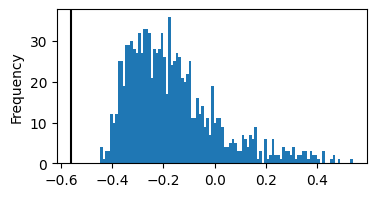

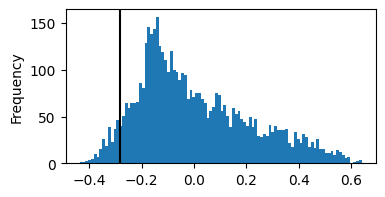

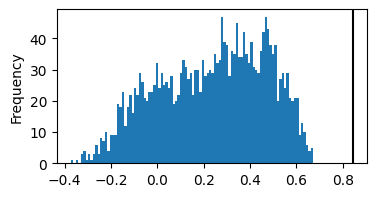

In [8]:
for y, sub_df in df_train_first.groupby("y"):
    ax = plt.gca()
    sub_df["pred"].plot.hist(bins=100, label=y, ax=ax, figsize=(4, 2))
    plt.axvline(y, color="black")
    plt.show()

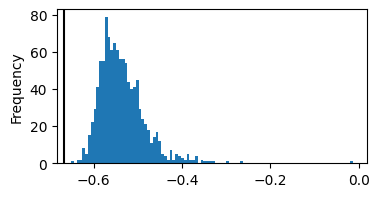

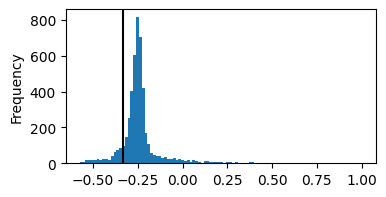

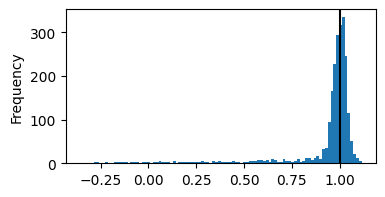

In [9]:
for y, sub_df in df_train_last.groupby("y"):
    ax = plt.gca()
    sub_df["pred"].plot.hist(bins=100, label=y, ax=ax, figsize=(4, 2))
    plt.axvline(y, color="black")
    plt.show()

In [57]:
err_df = df_train_last.copy()
err_df["err"] = (err_df["pred"] - err_df["y"]) ** 2
err_df.sort_values("err", ascending=False, inplace=True)
display(err_df.head())
ex_idx = err_df.index[1]

ex_td = td_train[ex_idx]
ex_df = {}
for k, c in [
    (("inps", "private", "player_idx"), "player"),
    (("inps", "private", "trick"), "trick"),
    ("values", "value"),
]:
    ex_df[c] = ex_td[k]
ex_df = pd.DataFrame(ex_df)
ex_valid_actions = ex_td["inps"]["valid_actions"]
ex_action_idxs = ex_td["actions"]
ex_actions = ex_valid_actions[torch.arange(len(ex_valid_actions)), ex_action_idxs, :]
ex_df["action_suit"] = ex_actions[:, 1]
ex_df["action_rank"] = ex_actions[:, 0]
display(ex_df)

,pred,y,err
1310,-0.359089,1.000000,1.847124
2995,0.999790,-0.333333,1.777218
1621,-0.303757,1.000000,1.699781
3535,-0.293424,1.000000,1.672945
3542,-0.276222,1.000000,1.628742


,player,trick,value,action_suit,action_rank
0,0,0,0.263816,0,0
1,1,0,0.332846,0,1
2,2,0,0.285974,0,3
3,2,1,0.204340,3,3
4,0,1,0.126761,3,1
5,1,1,0.109192,3,0
6,2,2,0.004164,3,2
7,0,2,0.064216,4,1
8,1,2,0.033825,1,3
9,0,3,0.026473,0,2


In [52]:
ex_td["unnorm_advantages"]

tensor([ 0.0133,  0.0043, -0.0071, -0.0229,  0.0455,  0.0005,  0.0391, -0.0109,
         0.0252,  0.0236, -0.0162, -0.0895, -0.0253,  0.0211, -0.0602, -0.0253,
        -0.0229, -0.1088])

In [55]:
ex_td["advantages"]

tensor([-0.4226, -0.4441, -0.4713, -0.5089, -0.3460, -0.4532, -0.3612, -0.4804,
        -0.3944, -0.3982, -0.4931, -0.6677, -0.5147, -0.4040, -0.5978, -0.5148,
        -0.5091, -0.7137])

In [54]:
ex_td["value_targets"]

tensor([-0.2810, -0.2838, -0.2867, -0.2896, -0.2925, -0.2955, -0.2984, -0.3015,
        -0.3045, -0.3076, -0.3107, -0.3138, -0.3170, -0.3202, -0.3234, -0.3267,
        -0.3300, -0.3333])

In [47]:
ex_td.keys()

_StringKeys(dict_keys(['inps', 'actions', 'orig_log_probs', 'rewards', 'frac_success', 'values', 'unnorm_advantages', 'advantages', 'value_targets']))